# PyTorch入門

In [1]:
%cd '/content/drive/My Drive/Colab Notebooks/introduction_to_pytorch_and_bert'

/content/drive/My Drive/Colab Notebooks/introduction_to_pytorch_and_bert


## ライブラリのインポート

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [4]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(SEED)

## データ（MNIST）の準備

In [5]:
# 手書き数字の画像データMNISTをダウンロード
mnist = fetch_openml('mnist_784', version=1, data_home='./data')

In [7]:
# データの前処理（画像データとラベルに分割）

X = mnist.data
y = mnist.target

y = np.array(y)
y = y.astype(np.int32)

この画像データのラベルは5です


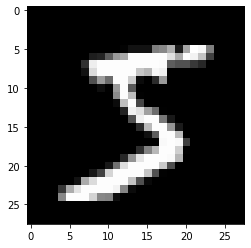

In [11]:
index = 0
plt.imshow(X[index].reshape(28, 28), cmap='gray')
print(f'この画像データのラベルは{y[index]:.0f}です')

In [12]:
# Dataset, DataLoderの作成

# データを訓練とテストに分割（6:1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=SEED)

In [13]:
# MNISTを1つずつ取り出すためのDatasetを定義

class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        X = self.X[index] / 255  # 0-255を0-1に正規化
        X = torch.Tensor(X)  # Tensor型に変換
        y = self.y[index]
        y = torch.LongTensor([y]).squeeze()  # LongTensor型に変換
        return X, y

In [14]:
# データセットを作成
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

# データローダーを作成
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## モデルの構築

In [16]:
class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.fc3(x)
        return output

In [31]:
model = Net(n_in=28*28*1, n_mid=100, n_out=10)  # ネットワークのオブジェクトを生成
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)


## 損失関数と最適化手法の設定

In [32]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()  

# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 学習と推論の設定

In [33]:
# 学習1回でやることを定義

def train(epoch):
    model.train()  # ネットワークを学習モードに切り替える

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, labels in tqdm(train_dataloader, total=len(train_dataloader)):
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
        output = model(data)  # 入力dataをinputし、出力を求める
        loss = criterion(output, labels)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する

    print(f'epoch{epoch}: done\n')

In [34]:
# 推論1回でやることを定義

def test():
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0
    # データローダーから1ミニバッチずつ取り出して計算する
    with torch.no_grad():  # 微分は推論では必要ない
        for data, labels in test_dataloader:

            output = model(data)  # 入力dataをinputし、出力を求める

            # 推論する
            preds = torch.argmax(output, dim=1)  # 確率が最大のラベルを求める
            correct += torch.sum(preds == labels) # 正解と一緒だったらカウントアップ

    # 正解率を出力
    data_num = len(test_dataloader.dataset)  # データの総数
    print(f'\nテストデータの正解率: {correct}/{data_num} ({100. * correct / data_num:.0f}%)\n')

In [35]:
# 学習なしで推論してみる
test()


テストデータの正解率: 1236/10000 (12%)



## 学習

In [36]:
for epoch in range(3):
    train(epoch)

test()


epoch0: done




epoch1: done




epoch2: done


テストデータの正解率: 9595/10000 (96%)



予測結果は6
この画像データの正解ラベルは6です


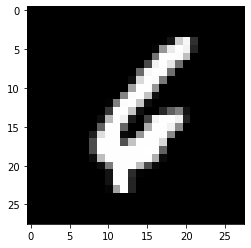

In [30]:
# 例えば2020番目の画像データを推論してみる

index = 68

model.eval()  # ネットワークを推論モードに切り替える
data = X_test[index]
data = torch.Tensor(data) / 255
data = data.view([1, -1])
output = model(data)  # 入力dataをinputし、出力を求める
pred = torch.argmax(output, dim=1)  # 確率が最大のラベルを求める

print(f"予測結果は{pred[0]}")

X_test_show = (X_test[index])
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print(f'この画像データの正解ラベルは{y_test[index]:.0f}です')